In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import seaborn as sns
warnings.filterwarnings('ignore')
df = pd.read_csv('train.csv')
df1 = df[df['city']=='LA']
zipcodedf = pd.read_csv('ZIP_Codes_and_Postal_Cities.csv')

In [2]:
#determine the number of missing entries in each column
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22453 entries, 6 to 74110
Data columns (total 29 columns):
id                        22453 non-null int64
log_price                 22453 non-null float64
property_type             22453 non-null object
room_type                 22453 non-null object
amenities                 22453 non-null object
accommodates              22453 non-null int64
bathrooms                 22387 non-null float64
bed_type                  22453 non-null object
cancellation_policy       22453 non-null object
cleaning_fee              22453 non-null bool
city                      22453 non-null object
description               22453 non-null object
first_review              17401 non-null object
host_has_profile_pic      22444 non-null object
host_identity_verified    22444 non-null object
host_response_rate        18410 non-null object
host_since                22444 non-null object
instant_bookable          22453 non-null object
last_review               174

## Data Cleaning 
##1. drop columns with a large of missing values
##2. We drop rows is 0

In [3]:
#deal with host response rate and fill 0 with no response rate
df1.loc[(df1['number_of_reviews']== 0) & (df1['host_response_rate'].isna()),'host_response_rate'] = 'No Respose Rate' 
df1['host_response_rate'].isna().sum()

1886

In [4]:
#deal with review score rating and fill 0 with no review
df1.loc[(df1['number_of_reviews']== 0) & (df1['review_scores_rating'].isna()),'review_scores_rating'] = 'No Review' 
df1['review_scores_rating'].isna().sum()

226

In [5]:
dfzip = zipcodedf[['ZIP Code','Postal City 1']]
dfzip['ZIP Code'] = dfzip['ZIP Code'].astype(str)
df2 = df1.merge(dfzip,left_on = 'zipcode', right_on = 'ZIP Code',how = 'left')
df2 = df2.drop(['ZIP Code','neighbourhood'], axis =1)
df2 = df2.rename(columns={'Postal City 1':'Neighbour'})
#delete columns that we did not need
df2 = df2.drop(['first_review','last_review','thumbnail_url'],axis = 1)
df2.isna().sum()

id                           0
log_price                    0
property_type                0
room_type                    0
amenities                    0
accommodates                 0
bathrooms                   66
bed_type                     0
cancellation_policy          0
cleaning_fee                 0
city                         0
description                  0
host_has_profile_pic         9
host_identity_verified       9
host_response_rate        1886
host_since                   9
instant_bookable             0
latitude                     0
longitude                    0
name                         0
number_of_reviews            0
review_scores_rating       226
zipcode                    295
bedrooms                    27
beds                        42
Neighbour                  313
dtype: int64

In [6]:
df2 = df2.dropna()

In [7]:
df2['review_scores_rating'] = pd.to_numeric(df2['review_scores_rating'],errors = 'coerce')
def convert_scores_buckets(val):
    if val == 100.0:
        return '10'
    elif val >= 90.0:
        return '9'
    elif val >= 80.0:
        return '8'
    elif val >= 70.0:
        return '7'
    elif val >= 60.0:
        return '6'
    elif val >= 50.0:
        return '5'
    else:
        return 'No Review'
df2['review_scores_rating'] = df2['review_scores_rating'].apply(convert_scores_buckets)
print(df2['review_scores_rating'].value_counts())

9            8991
No Review    4948
10           3878
8            1870
7             244
6             120
5              20
Name: review_scores_rating, dtype: int64


In [8]:
def response_score_rating(val):
    if val == '100%':
        return 'Actively Response'
    elif val == 'No Response Rate':
        return 'No Response'
    else:
        return 'Have Response'
df2['host_response_rate'] = df2['host_response_rate'].apply(response_score_rating)
print(df2['host_response_rate'].value_counts())

Actively Response    13667
Have Response         6404
Name: host_response_rate, dtype: int64


In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20071 entries, 0 to 22452
Data columns (total 26 columns):
id                        20071 non-null int64
log_price                 20071 non-null float64
property_type             20071 non-null object
room_type                 20071 non-null object
amenities                 20071 non-null object
accommodates              20071 non-null int64
bathrooms                 20071 non-null float64
bed_type                  20071 non-null object
cancellation_policy       20071 non-null object
cleaning_fee              20071 non-null bool
city                      20071 non-null object
description               20071 non-null object
host_has_profile_pic      20071 non-null object
host_identity_verified    20071 non-null object
host_response_rate        20071 non-null object
host_since                20071 non-null object
instant_bookable          20071 non-null object
latitude                  20071 non-null float64
longitude                 20

## Numerical numbers distribution

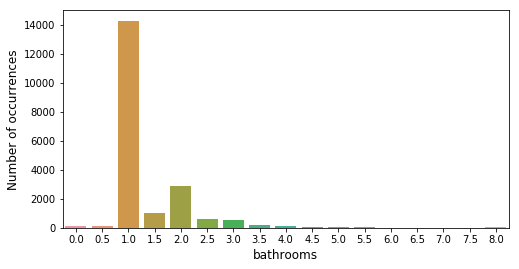

In [19]:
plt.figure(figsize = (8,4))
sns.countplot(df2['bathrooms'])
plt.xlabel('bathrooms',fontsize = 12)
plt.ylabel('Number of occurrences',fontsize = 12)
plt.show()

In [10]:
#analyze the number of accommodates
df2['accommodates'].value_counts()

2     8089
4     3238
1     2269
3     2016
6     1647
5     1012
8      679
7      339
10     300
16     157
12     111
9      101
14      50
11      31
15      20
13      12
Name: accommodates, dtype: int64

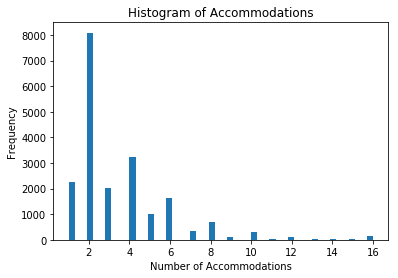

In [11]:
#visualize the number of accommodates
plt.hist(df2['accommodates'],bins = 50)
plt.title('Histogram of Accommodations')
plt.xlabel('Number of Accommodations')
plt.ylabel('Frequency')
plt.show()

We see that a majority of listing have accommodations for 1-4 people, 1 bed typically accommodates 2 individuals, so let's plot the bed instead of analyze how many of the listing are single bedroom listings.

In [12]:
df2['beds'].value_counts()

1.0     11321
2.0      4504
3.0      2069
4.0      1103
5.0       479
6.0       267
8.0        98
7.0        91
10.0       52
9.0        31
16.0       26
12.0       14
11.0        9
14.0        3
15.0        2
13.0        2
Name: beds, dtype: int64

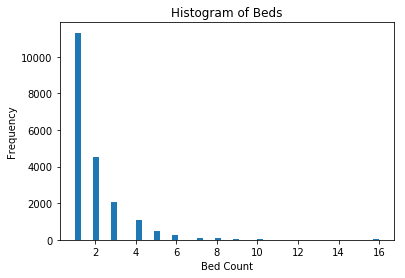

In [13]:
plt.hist(df2['beds'],bins = 50)
plt.title('Histogram of Beds')
plt.xlabel('Bed Count')
plt.ylabel('Frequency')
plt.show()

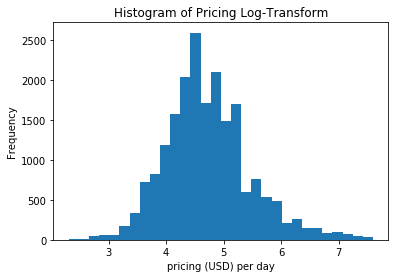

In [14]:
#visualize the distribution of price(target variable)
plt.hist(df2['log_price'],bins =30)
plt.title("Histogram of Pricing Log-Transform")
plt.xlabel("pricing (USD) per day")
plt.ylabel("Frequency")
plt.show()

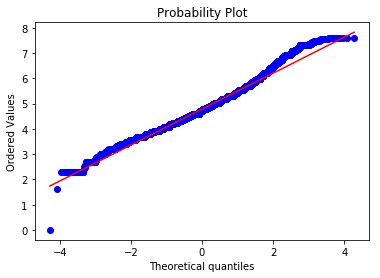

In [15]:
##qq plot for log-transform pricing
stats.probplot(df['log_price'],dist = "norm", plot = plt)
plt.show()

We see that after transformation, the distribution for price resembles that of a normal distribution. We see from the Q-Q plots that log-transforming the response variable yields a distribution that more closely resembles that of a normal distribution. This normality validation is important in order to fit the assumptions of linear regression models

In [16]:
df2.to_csv("CA.csv",index = False)